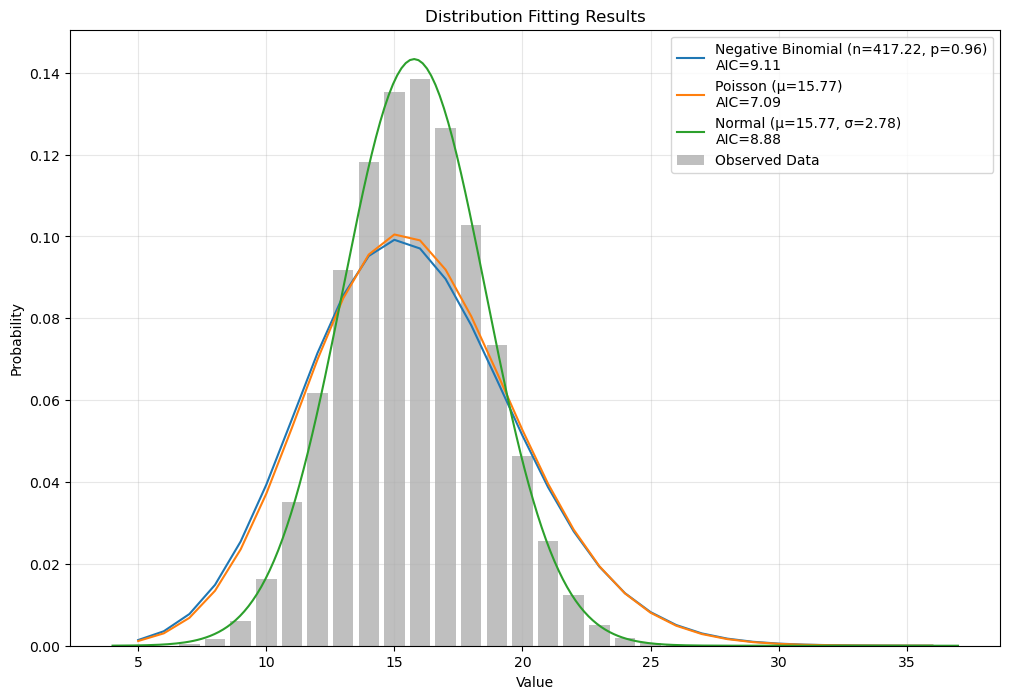


Data Summary:
Weighted Mean: 15.77
Weighted Standard Deviation: 2.78

Fit Summary:

Negative Binomial:
Parameters: (417.21789207118286, 0.9637732646559374)
AIC: 9.11

Poisson:
Parameters: (15.770310859516195,)
AIC: 7.09

Normal:
Parameters: (15.770310859516195, 2.7827734222414198)
AIC: 8.88

Goodness of Fit Tests:

Negative Binomial Chi-square statistic: 4119218.09

Poisson Chi-square statistic: 3663019.29

Normal Chi-square statistic: 43889.48


In [4]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

# Convert data to DataFrame
data = [
    (5, 1561), (6, 24189), (7, 177446), (8, 834638), (9, 2867955), 
    (10, 7725801), (11, 16608387), (12, 29270253), (13, 43458000), 
    (14, 56060584), (15, 64085869), (16, 65615931), (17, 59972682), 
    (18, 48703033), (19, 34847821), (20, 21913680), (21, 12070919), 
    (22, 5826221), (23, 2450720), (24, 898929), (25, 284696), (26, 78468), 
    (27, 18417), (28, 3781), (29, 647), (30, 114), (31, 23), (32, 8), 
    (33, 2), (34, 0), (35, 0), (36, 1)
]

df = pd.DataFrame(data, columns=['x', 'count'])

# Create weights for each observation
total_observations = df['count'].sum()
df['weight'] = df['count'] / total_observations

# Function to fit different distributions
def fit_distribution(data, weights, dist_name):
    if dist_name == "negative_binomial":
        def neg_bin_loglik(params):
            n, p = params
            return -np.sum(weights * stats.nbinom.logpmf(data, n, p))
        
        result = minimize(neg_bin_loglik, x0=[10, 0.5], bounds=[(0.001, None), (0.001, 0.999)])
        n, p = result.x
        return {"name": "Negative Binomial", "params": (n, p), "aic": 2*2 + 2*result.fun}
    
    elif dist_name == "poisson":
        mu = np.average(data, weights=weights)
        loglik = np.sum(weights * stats.poisson.logpmf(data, mu))
        return {"name": "Poisson", "params": (mu,), "aic": 2*1 - 2*loglik}
    
    elif dist_name == "normal":
        mu = np.average(data, weights=weights)
        sigma = np.sqrt(np.average((data - mu)**2, weights=weights))
        loglik = np.sum(weights * stats.norm.logpdf(data, mu, sigma))
        return {"name": "Normal", "params": (mu, sigma), "aic": 2*2 - 2*loglik}

# Fit distributions
distributions = []
for dist_name in ["negative_binomial", "poisson", "normal"]:
    try:
        fit = fit_distribution(df['x'].values, df['weight'].values, dist_name)
        distributions.append(fit)
    except:
        print(f"Failed to fit {dist_name}")

# Plot results
plt.figure(figsize=(12, 8))

# Plot histogram with density=True for proper scaling
plt.bar(df['x'], df['weight'], alpha=0.5, label='Observed Data', color='grey')

x_range = np.linspace(df['x'].min()-1, df['x'].max()+1, 200)

for dist in distributions:
    if dist['name'] == "Negative Binomial":
        n, p = dist['params']
        y = stats.nbinom.pmf(np.arange(df['x'].min(), df['x'].max()+1), n, p)
        plt.plot(np.arange(df['x'].min(), df['x'].max()+1), y, 
                label=f'Negative Binomial (n={n:.2f}, p={p:.2f})\nAIC={dist["aic"]:.2f}')
    
    elif dist['name'] == "Poisson":
        mu = dist['params'][0]
        y = stats.poisson.pmf(np.arange(df['x'].min(), df['x'].max()+1), mu)
        plt.plot(np.arange(df['x'].min(), df['x'].max()+1), y, 
                label=f'Poisson (μ={mu:.2f})\nAIC={dist["aic"]:.2f}')
    
    elif dist['name'] == "Normal":
        mu, sigma = dist['params']
        y = stats.norm.pdf(x_range, mu, sigma)
        plt.plot(x_range, y, 
                label=f'Normal (μ={mu:.2f}, σ={sigma:.2f})\nAIC={dist["aic"]:.2f}')

plt.title('Distribution Fitting Results')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate mean and variance of the data
weighted_mean = np.average(df['x'], weights=df['count'])
weighted_var = np.average((df['x'] - weighted_mean)**2, weights=df['count'])

print("\nData Summary:")
print(f"Weighted Mean: {weighted_mean:.2f}")
print(f"Weighted Standard Deviation: {np.sqrt(weighted_var):.2f}")

print("\nFit Summary:")
for dist in distributions:
    print(f"\n{dist['name']}:")
    print(f"Parameters: {dist['params']}")
    print(f"AIC: {dist['aic']:.2f}")

# Calculate goodness of fit metrics
print("\nGoodness of Fit Tests:")
for dist in distributions:
    if dist['name'] == "Normal":
        mu, sigma = dist['params']
        expected_probs = stats.norm.pdf(df['x'], mu, sigma)
    elif dist['name'] == "Poisson":
        mu = dist['params'][0]
        expected_probs = stats.poisson.pmf(df['x'], mu)
    elif dist['name'] == "Negative Binomial":
        n, p = dist['params']
        expected_probs = stats.nbinom.pmf(df['x'], n, p)
    
    # Scale expected probabilities to match observed weights
    expected_probs = expected_probs / expected_probs.sum()
    
    # Calculate chi-square statistic
    chi_square = np.sum(df['count'] * ((df['weight'] - expected_probs)**2 / expected_probs))
    print(f"\n{dist['name']} Chi-square statistic: {chi_square:.2f}")